In [1]:
import torch
from torch.utils.data import Dataset
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

class change_detection_dataset(Dataset):
    def __init__(self,root_path) -> None:
        super().__init__()
        self.pre_change_path=os.path.join(root_path,"A")
        self.post_change_path=os.path.join(root_path,"B")
        self.change_label_path=os.path.join(root_path,"label")
        self.fname_list=os.listdir(self.pre_change_path)
    def __getitem__(self, index):
        fname=self.fname_list[index]
        pre_img=Image.open(os.path.join(self.pre_change_path,fname)).convert("RGB")
        post_img=Image.open(os.path.join(self.post_change_path,fname)).convert("RGB")
        change_label=Image.open(os.path.join(self.change_label_path,fname)).convert("1")
        transform=transforms.Compose([
            transforms.ToTensor()
        ])
        pre_tensor=transform(pre_img)
        post_tensor=transform(post_img)
        label_tensor=transform(change_label)
        return {'pre':pre_tensor,'post':post_tensor,'label':label_tensor,'fname':fname}
    def __len__(self):
        return len(self.fname_list)

In [2]:
train_path="D:\\Datasets\\Levir_croped_256\\LEVIR_CD\\train"
test_path="D:\\Datasets\\Levir_croped_256\\LEVIR_CD\\test"
val_path="D:\\Datasets\\Levir_croped_256\\LEVIR_CD\\val"

if __name__=="__main__":
    train_loader=DataLoader(change_detection_dataset(root_path=train_path),batch_size=8,shuffle=True,num_workers=0,pin_memory=False)
    test_loader=DataLoader(change_detection_dataset(root_path=test_path),batch_size=4,shuffle=False,num_workers=0,pin_memory=False)
    val_loader=DataLoader(change_detection_dataset(root_path=val_path),batch_size=4,shuffle=False,num_workers=0,pin_memory=False)

fname=train_16_8.png


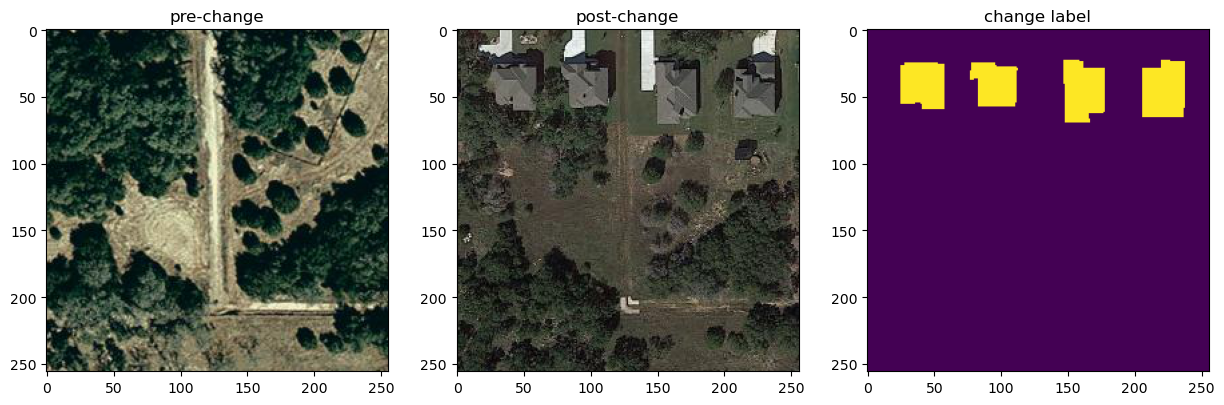

In [3]:
for i, data in enumerate(train_loader):
        pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
        fig=plt.figure(figsize=(15,5))

        preplot=fig.add_subplot(131)
        preplot.imshow(pre_tensor[1,:,:,:].permute(1,2,0).numpy())
        preplot.set_title("pre-change")

        postplot=fig.add_subplot(132)
        postplot.set_title("post-change")
        postplot.imshow(post_tensor[1,:,:,:].permute(1,2,0).numpy())

        labelplot=fig.add_subplot(133)
        labelplot.set_title("change label")
        labelplot.imshow(label_tensor[1,:,:,:].permute(1,2,0).numpy())
        # transforms.ToPILImage()(pre_tensor[0,:,:,:])
        # transforms.ToPILImage()(post_tensor[0,:,:,:])
        # transforms.ToPILImage()(label_tensor[0,:,:,:])
        print(f'fname={fname[0]}')
        break

In [14]:
import torch
import torch.nn as nn

class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding, groups=4):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding, groups=groups    ## added groups
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1, groups=groups)  ## added groups,
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1, groups=groups),  ## added groups
            nn.BatchNorm2d(output_dim),                                   
        )


    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)


class ResUnet(nn.Module):
    def __init__(self, channel=3, filters=[32,64, 128, 256, 512]):
        super(ResUnet, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.residual_conv_1 = ResidualConv(filters[0], filters[1], 2, 1)
        self.residual_conv_2 = ResidualConv(filters[1], filters[2], 2, 1)
        self.residual_conv_3 = ResidualConv(filters[2], filters[3], 2, 1)
        self.bridge = ResidualConv(filters[3], filters[4], 2, 1)

        self.upsample_1 = Upsample(filters[4], filters[4], 2, 2)
        self.up_residual_conv1 = ResidualConv(filters[4] + filters[3], filters[3], 1, 1)

        self.upsample_2 = Upsample(filters[3], filters[3], 2, 2)
        self.up_residual_conv2 = ResidualConv(filters[3] + filters[2], filters[2], 1, 1)

        self.upsample_3 = Upsample(filters[2], filters[2], 2, 2)
        self.up_residual_conv3 = ResidualConv(filters[2] + filters[1], filters[1], 1, 1)

        self.upsample_4 = Upsample(filters[1], filters[1], 2, 2)
        self.up_residual_conv4 = ResidualConv(filters[1] + filters[0], filters[0], 1, 1)

        self.up_residual_conv5 = ResidualConv(filters[0],filters[0],1,1)

        self.output_layer = nn.Sequential(
            ResidualConv(filters[0],1,1,1, groups=1),
            # nn.Softmax(dim=1)
            nn.Sigmoid()
        )


    def forward(self,m,n):

        # Encode1
        #stage1
        x1 = self.input_layer(m) + self.input_skip(m)    #950*750
        # print ("x1 shape is" , x1.shape)  #8, 32, 256, 256

        #stage2
        x2 = self.residual_conv_1(x1) #475*375
        # print ("x2 shape is" , x2.shape)  #8, 64, 128, 128

        #stage3
        x3 = self.residual_conv_2(x2)
        x4 = self.residual_conv_3(x3)
        x5 = self.bridge(x4)
        # Encode2
        y1 = self.input_layer(n) + self.input_skip(n) #32*160*160
        y2 = self.residual_conv_1(y1) #64*80*80
        y3 = self.residual_conv_2(y2) #128*40*40
        y4 = self.residual_conv_3(y3)#256*20*20
        # Bridge

        y5 = self.bridge(y4)#512*10*10

        # Decode
        x5 = self.upsample_1(x5) #512*20*20

        x6 = torch.cat([x5,torch.abs(x4-y4)],dim=1) # 768*20*20
        x7 = self.up_residual_conv1(x6) #256*20*20

        x7 = self.upsample_2(x7) #256*40*40

        x8 = torch.cat([x7, torch.abs(x3-y3)], dim=1) #384*40*40

        x9 = self.up_residual_conv2(x8) #128*40*40

        x9 = self.upsample_3(x9) #128*80*80
        x10 = torch.cat([x9, torch.abs(x2-y2)], dim=1) #192*80*80

        x11 = self.up_residual_conv3(x10) #64*80*80

        x11 = self.upsample_4(x11) #64*160*160
        x12 = torch.cat([x11, torch.abs(x1-y1)], dim=1) #96*160*160

        x13 = self.up_residual_conv4(x12)
        x14 = self.up_residual_conv5(x13)
        output = self.output_layer(x14)

        return output

In [15]:
T1= torch.rand(8,3,256,256)
T2= torch.rand(8,3,256,256)
model=ResUnet()

output=model(T1,T2)
print(output.shape)
print(label_tensor.shape)

torch.Size([8, 1, 256, 256])
torch.Size([4, 1, 256, 256])


In [16]:
def train(model, train_loader, val_loader, optimizer, loss_function, device, num_epochs, save_path):
    for epoch in range(num_epochs):
        loss_list=[]
        model.train()
        for _, data in enumerate(train_loader):
            optimizer.zero_grad()
            pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
            pre_tensor = pre_tensor.to(device)
            post_tensor = post_tensor.to(device)
            label_tensor = label_tensor.to(device)
            prediction = model(pre_tensor, post_tensor)
            total_loss=loss_function(prediction,label_tensor)
            loss_list.append(total_loss.item()) #only append the loss value and ignore the grad to save memory
            total_loss.backward()
            optimizer.step()
        loss_avg=sum(loss_list)/len(loss_list)
        print(f'Epoch {epoch} training completed, the average loss is {loss_avg}.')

        if (epoch+1) % 10==0:
            model.eval()
            OA_list=[]
            for _, data in enumerate(val_loader):
                pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
                pre_tensor = pre_tensor.to(device)
                post_tensor = post_tensor.to(device)
                label_tensor = label_tensor.to(device)
                probs = model(pre_tensor, post_tensor)
                prediction = torch.where(probs>0.5,1,0)
                true_count=torch.sum(prediction==label_tensor)
                OA=true_count/prediction.numel()
                OA_list.append(OA)
            print("*"*10)
            print(f'Epoch {epoch} evaluation completed, the average OA is {sum(OA_list)/len(OA_list)}')
            print("*"*10)
            torch.save(model.state_dict(),os.path.join(save_path,"ResUnet"+str(epoch)+".pth"))

In [18]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.35, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss


In [19]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)
model=model.to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)
# loss_function=torch.nn.BCELoss()
loss_function=FocalLoss()
num_epochs=30
save_path="E://VS Projects//test_7-2-2025_ResUNet_Levir-CD//checkpoint5-2"
os.makedirs(save_path, exist_ok=True)
train(model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, loss_function=loss_function, device=device, num_epochs=num_epochs, save_path=save_path)

cuda
Epoch 0 training completed, the average loss is 0.06952857447322458.
Epoch 1 training completed, the average loss is 0.05256221746094525.
Epoch 2 training completed, the average loss is 0.0482476920587942.
Epoch 3 training completed, the average loss is 0.04537510313093662.
Epoch 4 training completed, the average loss is 0.04286612709984183.
Epoch 5 training completed, the average loss is 0.04045589920133352.
Epoch 6 training completed, the average loss is 0.0385037079686299.
Epoch 7 training completed, the average loss is 0.036308023845776916.
Epoch 8 training completed, the average loss is 0.0338200757978484.
Epoch 9 training completed, the average loss is 0.0323769215028733.
**********
Epoch 9 evaluation completed, the average OA is 0.7703146934509277
**********
Epoch 10 training completed, the average loss is 0.02993974124547094.
Epoch 11 training completed, the average loss is 0.028310033783782274.
Epoch 12 training completed, the average loss is 0.026198393665254116.
Epoch 1

In [20]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

In [21]:
from torchvision.utils import save_image

model = ResUnet()
model=model.to(device)
model.load_state_dict(torch.load("E://VS Projects//test_7-2-2025_ResUNet_Levir-CD//checkpoint5-2//ResUnet29.pth"))

test_results_path="E://VS Projects//test_7-2-2025_ResUNet_Levir-CD//test_results5-2"
os.makedirs(test_results_path,exist_ok=True)
TP=0
TN=0
FP=0
FN=0
for _, data in enumerate(test_loader):
    pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
    pre_tensor = pre_tensor.to(device)
    post_tensor = post_tensor.to(device)
    label_tensor = label_tensor.to(device)
    probs = model(pre_tensor, post_tensor)
    prediction = torch.where(probs>0.5,1.0,0.0)
    true_positives, false_positives, true_negatives, false_negatives = confusion(prediction,label_tensor)
    TP+=true_positives
    TN+=true_negatives
    FP+=false_positives
    FN+=false_negatives
    for i in range(prediction.shape[0]):
        save_image(prediction[i,:,:,:].cpu(), os.path.join(test_results_path, fname[i]))


C:\Users\G7\AppData\Local\Temp\ipykernel_21392\2034466032.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("E://VS Projects//test_7-2-202

fname=test_8_6.png


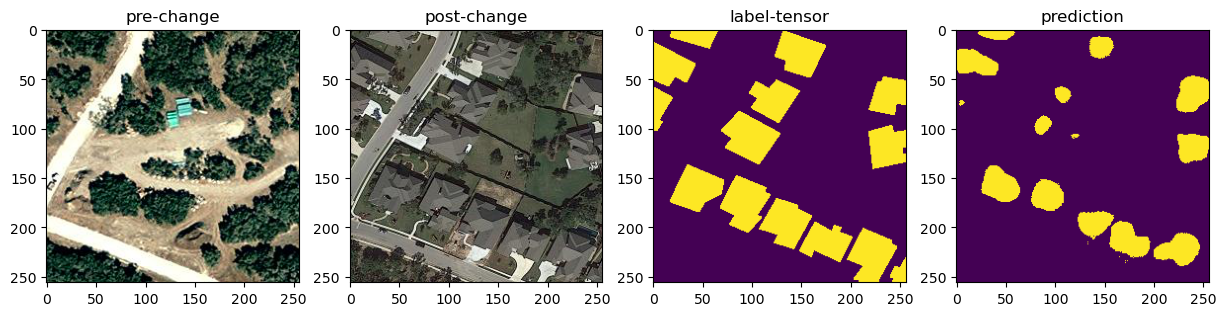

In [22]:
import matplotlib.pyplot as plt
import numpy as np

pre_tensor, post_tensor, label_tensor, fname = data["pre"], data["post"], data["label"], data["fname"]
fig=plt.figure(figsize=(15,5))

preplot=fig.add_subplot(141)
preplot.imshow(pre_tensor[1,:,:,:].permute(1,2,0).numpy())
preplot.set_title("pre-change")

postplot=fig.add_subplot(142)
postplot.set_title("post-change")
postplot.imshow(post_tensor[1,:,:,:].permute(1,2,0).numpy())

postplot=fig.add_subplot(143)
postplot.set_title("label-tensor")
postplot.imshow(label_tensor[1,:,:,:].permute(1,2,0).numpy())

labelplot=fig.add_subplot(144)
labelplot.set_title("prediction")
labelplot.imshow(prediction[1,:,:,:].permute(1,2,0).cpu().numpy())
# transforms.ToPILImage()(pre_tensor[0,:,:,:])
# transforms.ToPILImage()(post_tensor[0,:,:,:])
# transforms.ToPILImage()(label_tensor[0,:,:,:])
print(f'fname={fname[0]}')

In [24]:
OA=(TP+TN)/(TP+TN+FP+FN)
Precision=TP/(TP+FP)
Recall=TP/(TP+FN)
F1_score=2*Precision*Recall/(Precision+Recall)

print(f'OA={OA:.3f}, Precision={Precision:.3f}, Recall={Recall:.3f}, F1-score={F1_score:.3f}')

OA=0.961, Precision=0.463, Recall=0.548, F1-score=0.502


In [25]:
import torchinfo
torchinfo.summary(model, input_size=[(8,3,256,256),(8,3,256,256)])

Layer (type:depth-idx)                   Output Shape              Param #
ResUnet                                  [8, 1, 256, 256]          --
├─Sequential: 1-1                        [8, 32, 256, 256]         --
│    └─Conv2d: 2-1                       [8, 32, 256, 256]         896
│    └─BatchNorm2d: 2-2                  [8, 32, 256, 256]         64
│    └─ReLU: 2-3                         [8, 32, 256, 256]         --
│    └─Conv2d: 2-4                       [8, 32, 256, 256]         9,248
├─Sequential: 1-2                        [8, 32, 256, 256]         --
│    └─Conv2d: 2-5                       [8, 32, 256, 256]         896
├─ResidualConv: 1-3                      [8, 64, 128, 128]         --
│    └─Sequential: 2-6                   [8, 64, 128, 128]         --
│    │    └─BatchNorm2d: 3-1             [8, 32, 256, 256]         64
│    │    └─ReLU: 3-2                    [8, 32, 256, 256]         --
│    │    └─Conv2d: 3-3                  [8, 64, 128, 128]         4,672
│    │ 